# Brain tumor detection with Faster-R-CNN.

In [1]:
!pip install pycocotools

!pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

from utils_brain_tumor_specific import get_transform, collate_fn
from dataset_class import brain_image_Dataset
from train_n_eval import train_one_epoch, evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 3.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 3.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 27.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 1.2 MB/s eta 0:00:00:00:01


## Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

## Unzip dataset

In [6]:
import zipfile as zf
files = zf.ZipFile("brain_tumor_tidy-20240507T035014Z-001.zip", 'r')
files.extractall('/brain_tumor_tidy')
files.close()

In [7]:
# %cd /brain_tumor_tidy/brain_tumor_tidy 
!pwd

/


## Show images in the brain tumor dataset

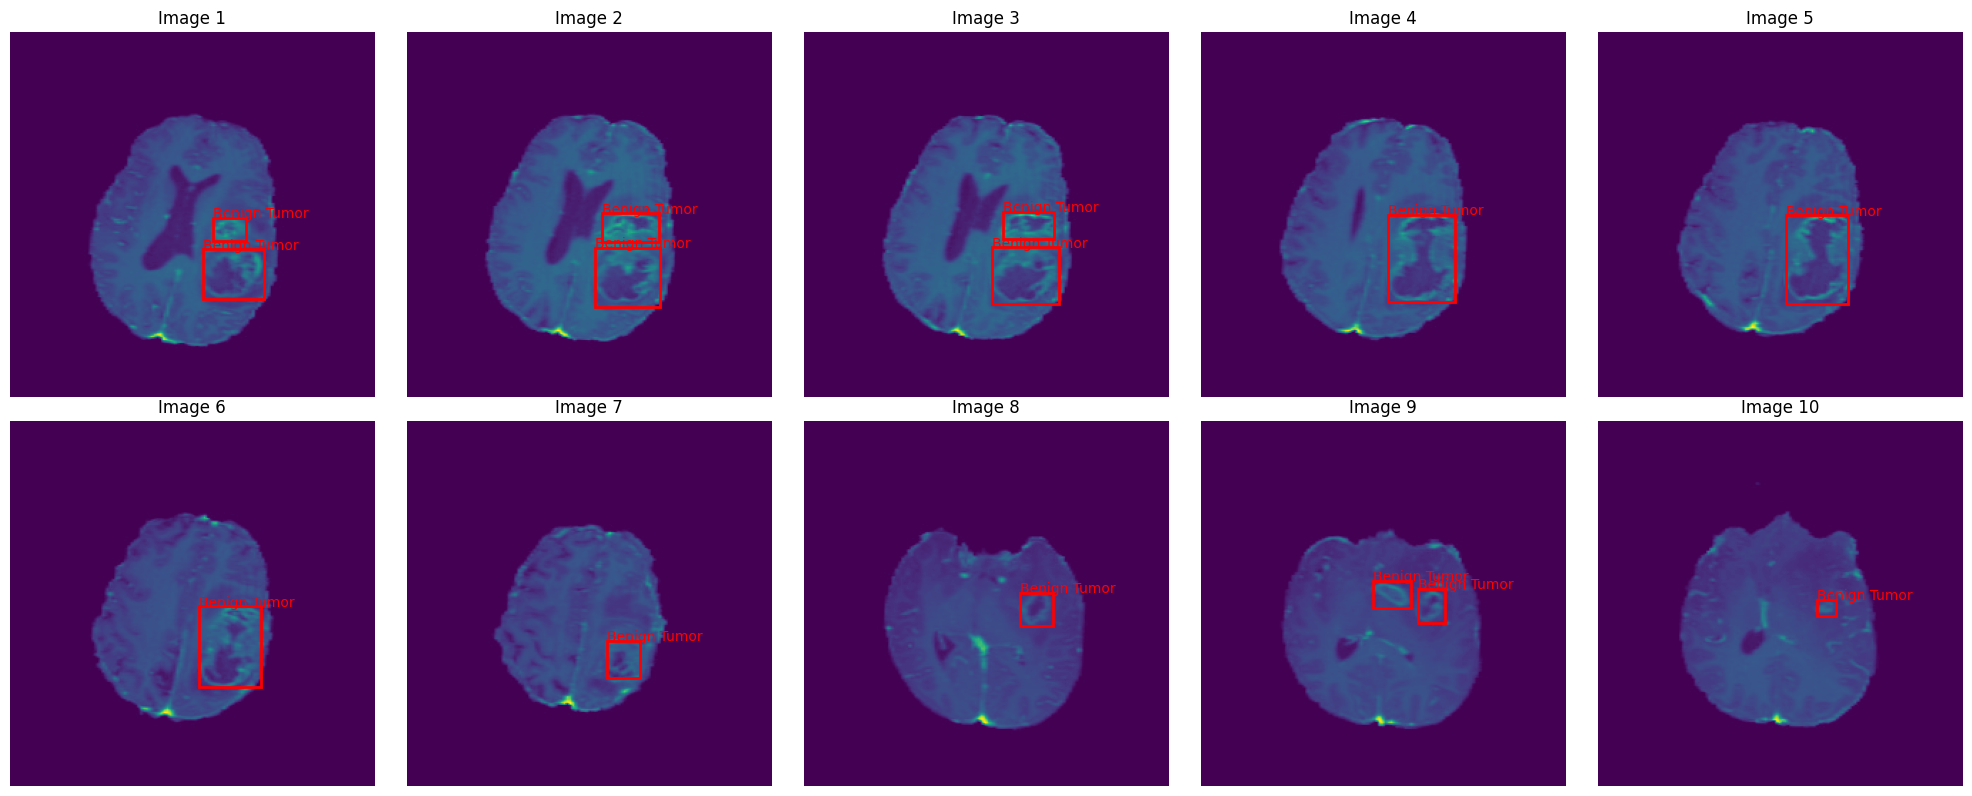

In [6]:
# Set the folder path
folder_path = "/brain_tumor_tidy/brain_tumor_tidy/axial_t1wce_2_class/images/test/"

# Iterate over the first 10 images in the folder
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for i, (ax, filename) in enumerate(zip(axs, sorted(os.listdir(folder_path))[:10])):
    if filename.endswith(".jpg"):
        # Read image and wrap image into torchvision tv_tensors
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = tv_tensors.Image(img)

        # Get the image size
        width, height = F.get_size(img)

        # Read the .txt file with the labels and bounding boxes
        label_path = os.path.join("/brain_tumor_tidy/brain_tumor_tidy/axial_t1wce_2_class/labels/test/", filename.replace(".jpg", ".txt"))
        with open(label_path) as file:
            lines = file.readlines()

        # Extract labels and fractional bounding boxes: works on one line or multiple lines
        labels = [line.strip().split()[0] for line in lines]
        bboxes_frac = [line.strip().split()[1:5] for line in lines]
        bboxes_frac = [[float(x) for x in bbox] for bbox in bboxes_frac]

        # Convert fractional bounding boxes to pixel coordinates
        bboxes_pixels = []
        for bbox_frac in bboxes_frac:
            x_center = bbox_frac[0] * width
            y_center = bbox_frac[1] * height
            bbox_width = bbox_frac[2] * width
            bbox_height = bbox_frac[3] * height
            bboxes_pixels.append([
                x_center - bbox_width / 2,  # x_min
                y_center - bbox_height / 2,  # y_min
                x_center + bbox_width / 2,  # x_max
                y_center + bbox_height / 2,  # y_max
            ])

        # Convert the image to a NumPy array
        img_np = img.permute(1, 2, 0).numpy()

        # Plot the image
        ax.imshow(img_np)

        # Create and add Rectangle patches for all bounding boxes
        for bbox_pixels, label in zip(bboxes_pixels, labels):
            rect = Rectangle((bbox_pixels[0], bbox_pixels[1]),
                             bbox_pixels[2] - bbox_pixels[0],
                             bbox_pixels[3] - bbox_pixels[1],
                             linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Label the bounding box
            label_text = "Benign Tumor" if label == "0" else "Malignant Tumor"
            ax.text(bbox_pixels[0], bbox_pixels[1], label_text, fontsize=10, color='r')

        ax.set_title(f"Image {i+1}")
        ax.axis('off')

plt.tight_layout()
plt.savefig("ground_truth_axial.png")
plt.show()

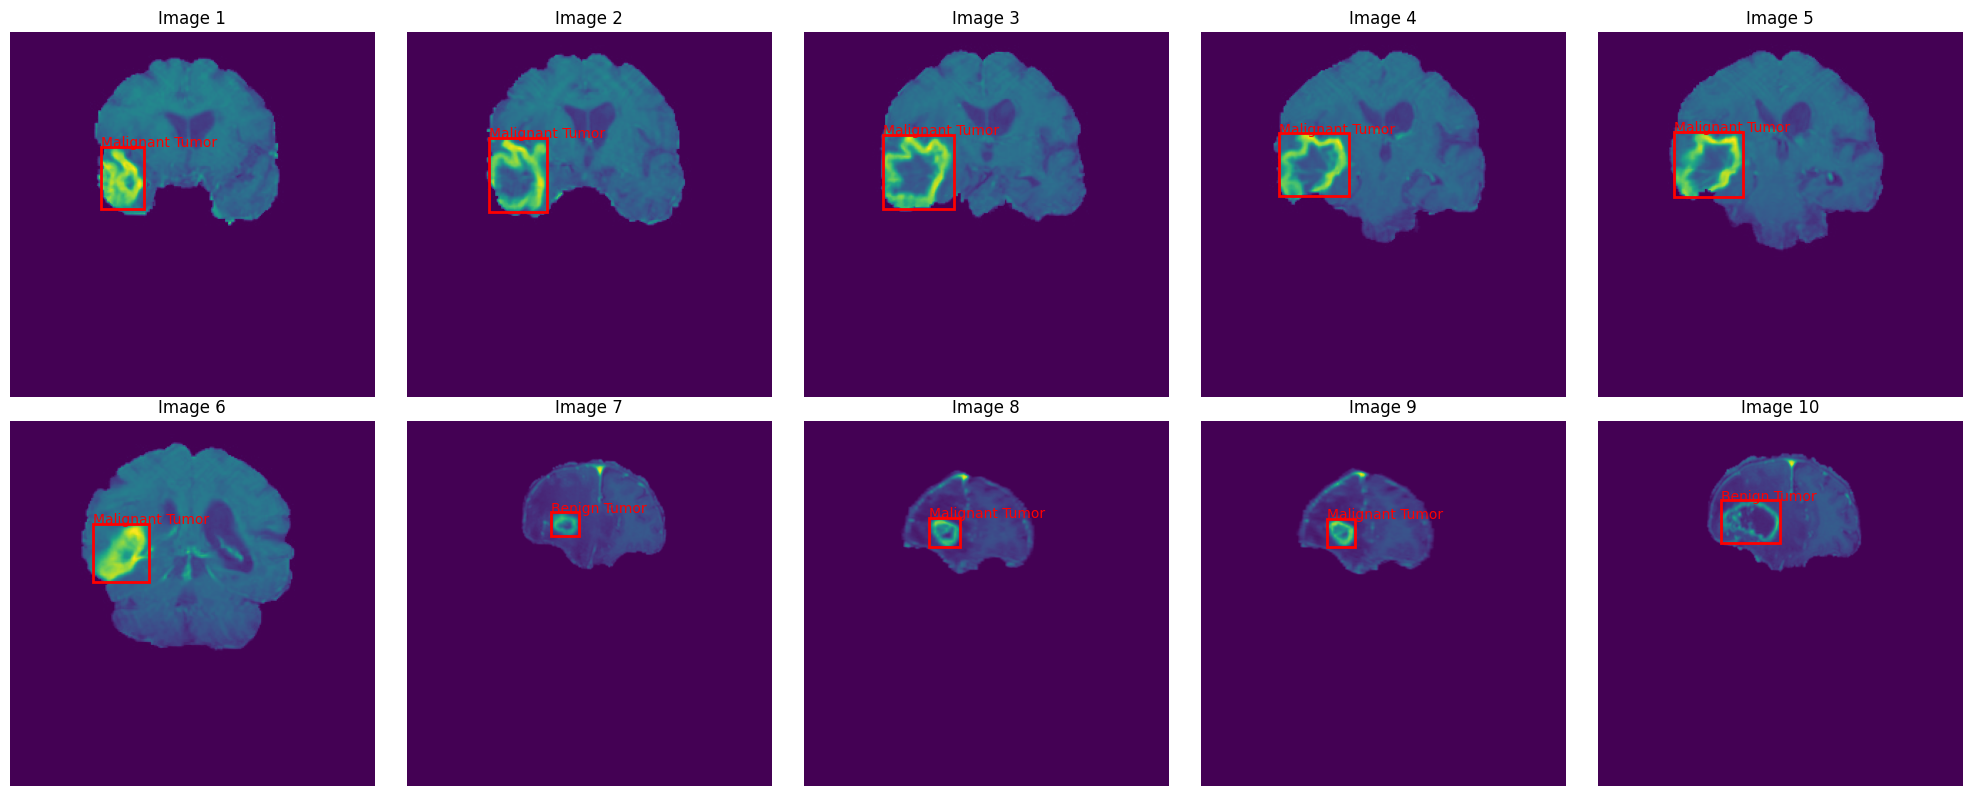

In [7]:
# Set the folder path
folder_path = "/brain_tumor_tidy/brain_tumor_tidy/coronal_t1wce_2_class/images/test/"

# Iterate over the first 10 images in the folder
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for i, (ax, filename) in enumerate(zip(axs, sorted(os.listdir(folder_path))[:10])):
    if filename.endswith(".jpg"):
        # Read image and wrap image into torchvision tv_tensors
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = tv_tensors.Image(img)

        # Get the image size
        width, height = F.get_size(img)

        # Read the .txt file with the labels and bounding boxes
        label_path = os.path.join("/brain_tumor_tidy/brain_tumor_tidy/coronal_t1wce_2_class/labels/test/", filename.replace(".jpg", ".txt"))
        with open(label_path) as file:
            lines = file.readlines()

        # Extract labels and fractional bounding boxes: works on one line or multiple lines
        labels = [line.strip().split()[0] for line in lines]
        bboxes_frac = [line.strip().split()[1:5] for line in lines]
        bboxes_frac = [[float(x) for x in bbox] for bbox in bboxes_frac]

        # Convert fractional bounding boxes to pixel coordinates
        bboxes_pixels = []
        for bbox_frac in bboxes_frac:
            x_center = bbox_frac[0] * width
            y_center = bbox_frac[1] * height
            bbox_width = bbox_frac[2] * width
            bbox_height = bbox_frac[3] * height
            bboxes_pixels.append([
                x_center - bbox_width / 2,  # x_min
                y_center - bbox_height / 2,  # y_min
                x_center + bbox_width / 2,  # x_max
                y_center + bbox_height / 2,  # y_max
            ])

        # Convert the image to a NumPy array
        img_np = img.permute(1, 2, 0).numpy()

        # Plot the image
        ax.imshow(img_np)

        # Create and add Rectangle patches for all bounding boxes
        for bbox_pixels, label in zip(bboxes_pixels, labels):
            rect = Rectangle((bbox_pixels[0], bbox_pixels[1]),
                             bbox_pixels[2] - bbox_pixels[0],
                             bbox_pixels[3] - bbox_pixels[1],
                             linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Label the bounding box
            label_text = "Benign Tumor" if label == "0" else "Malignant Tumor"
            ax.text(bbox_pixels[0], bbox_pixels[1], label_text, fontsize=10, color='r')

        ax.set_title(f"Image {i+1}")
        ax.axis('off')

plt.tight_layout()
plt.savefig("ground_truth_coronal.png")
plt.show()

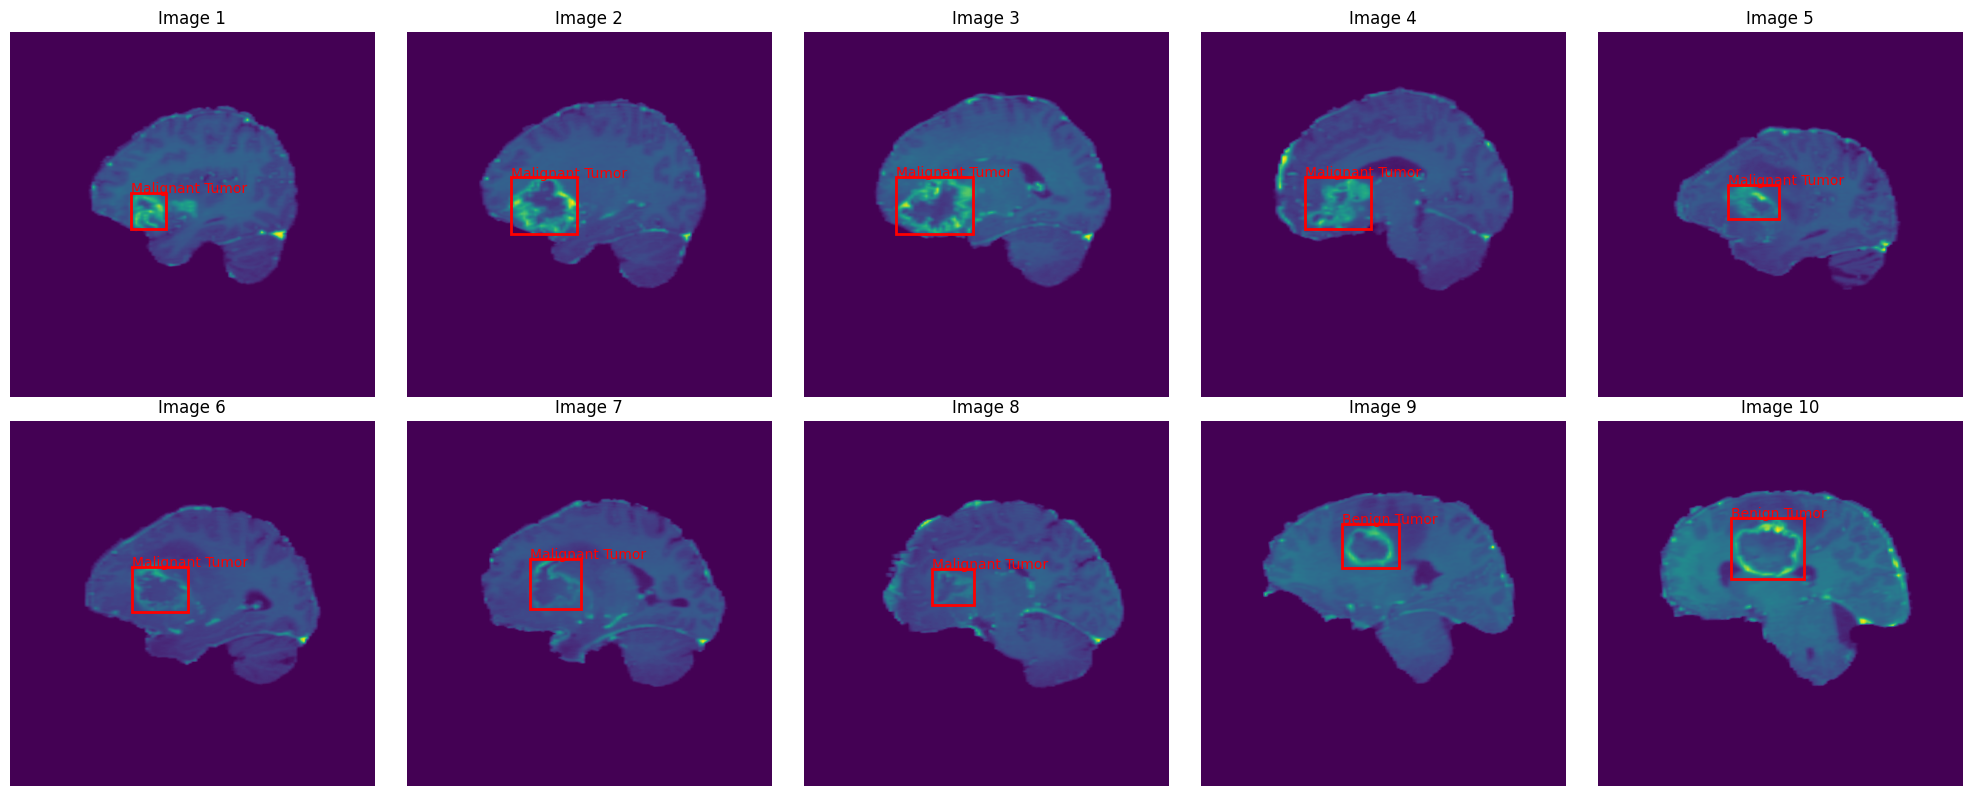

In [26]:
# Set the folder path
folder_path = "/brain_tumor_tidy/brain_tumor_tidy/sagittal_t1wce_2_class/images/test/"

# Iterate over the first 10 images in the folder
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for i, (ax, filename) in enumerate(zip(axs, sorted(os.listdir(folder_path))[:10])):
    if filename.endswith(".jpg"):
        # Read image and wrap image into torchvision tv_tensors
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = tv_tensors.Image(img)

        # Get the image size
        width, height = F.get_size(img)

        # Read the .txt file with the labels and bounding boxes
        label_path = os.path.join("/brain_tumor_tidy/brain_tumor_tidy/sagittal_t1wce_2_class/labels/test/", filename.replace(".jpg", ".txt"))
        with open(label_path) as file:
            lines = file.readlines()

        # Extract labels and fractional bounding boxes: works on one line or multiple lines
        labels = [line.strip().split()[0] for line in lines]
        bboxes_frac = [line.strip().split()[1:5] for line in lines]
        bboxes_frac = [[float(x) for x in bbox] for bbox in bboxes_frac]

        # Convert fractional bounding boxes to pixel coordinates
        bboxes_pixels = []
        for bbox_frac in bboxes_frac:
            x_center = bbox_frac[0] * width
            y_center = bbox_frac[1] * height
            bbox_width = bbox_frac[2] * width
            bbox_height = bbox_frac[3] * height
            bboxes_pixels.append([
                x_center - bbox_width / 2,  # x_min
                y_center - bbox_height / 2,  # y_min
                x_center + bbox_width / 2,  # x_max
                y_center + bbox_height / 2,  # y_max
            ])

        # Convert the image to a NumPy array
        img_np = img.permute(1, 2, 0).numpy()

        # Plot the image
        ax.imshow(img_np)

        # Create and add Rectangle patches for all bounding boxes
        for bbox_pixels, label in zip(bboxes_pixels, labels):
            rect = Rectangle((bbox_pixels[0], bbox_pixels[1]),
                             bbox_pixels[2] - bbox_pixels[0],
                             bbox_pixels[3] - bbox_pixels[1],
                             linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Label the bounding box
            label_text = "Benign Tumor" if label == "0" else "Malignant Tumor"
            ax.text(bbox_pixels[0], bbox_pixels[1], label_text, fontsize=10, color='r')

        ax.set_title(f"Image {i+1}")
        ax.axis('off')

plt.tight_layout()
plt.savefig("ground_truth_sagittal.png")
plt.show()

## Define the model
- Fine tune from a pretrained model
- Model: Faster R-CNN

In [9]:
def get_model_detection(num_classes): # 2 classes (tumor) + background
    # load a detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # model # first layer is transform: (transform): GeneralizedRCNNTransform(
                        # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        # Resize(min_size=(800,), max_size=1333, mode='bilinear'))
    # Set the maximum number of detections to 10
    model.roi_heads.detections_per_img = 10
    return model

# Main

## Axial

In [31]:
# our dataset has three classes only - background, -ve tumor, +ve tumor
num_classes = 3
# use our dataset and defined transformations
dataset = brain_image_Dataset('/brain_tumor_tidy/brain_tumor_tidy/axial_t1wce_2_class', get_transform(train=True), process="train")
dataset_test = brain_image_Dataset('/brain_tumor_tidy/brain_tumor_tidy/axial_t1wce_2_class', get_transform(train=False), process="test")

# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# get the model using our helper function
model = get_model_detection(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.004,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 3 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/148]  eta: 0:01:05  lr: 0.000031  loss: 1.1940 (1.1940)  loss_classifier: 1.0688 (1.0688)  loss_box_reg: 0.0019 (0.0019)  loss_objectness: 0.1189 (0.1189)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 0.4450  data: 0.1622  max mem: 2014
Epoch: [0]  [100/148]  eta: 0:00:12  lr: 0.002750  loss: 0.2011 (0.3031)  loss_classifier: 0.0938 (0.1666)  loss_box_reg: 0.0586 (0.0593)  loss_objectness: 0.0334 (0.0714)  loss_rpn_box_reg: 0.0049 (0.0058)  time: 0.2461  data: 0.0056  max mem: 2014
Epoch: [0]  [147/148]  eta: 0:00:00  lr: 0.004000  loss: 0.1596 (0.2700)  loss_classifier: 0.0878 (0.1434)  loss_box_reg: 0.0502 (0.0617)  loss_objectness: 0.0270 (0.0595)  loss_rpn_box_reg: 0.0030 (0.0055)  time: 0.2444  data: 0.0056  max mem: 2014
Epoch: [0] Total time: 0:00:37 (0.2504 s / it)
creating index...
index created!
Test: [ 0/38] eta: 0:00:10 model_time: 0.0930 (0.0930) evaluator_time: 0.0038 (0.0038) time: 0.2795 data: 0.1816 max mem: 2014
Test: [37/38] eta: 0:00:00 model_time: 0.08

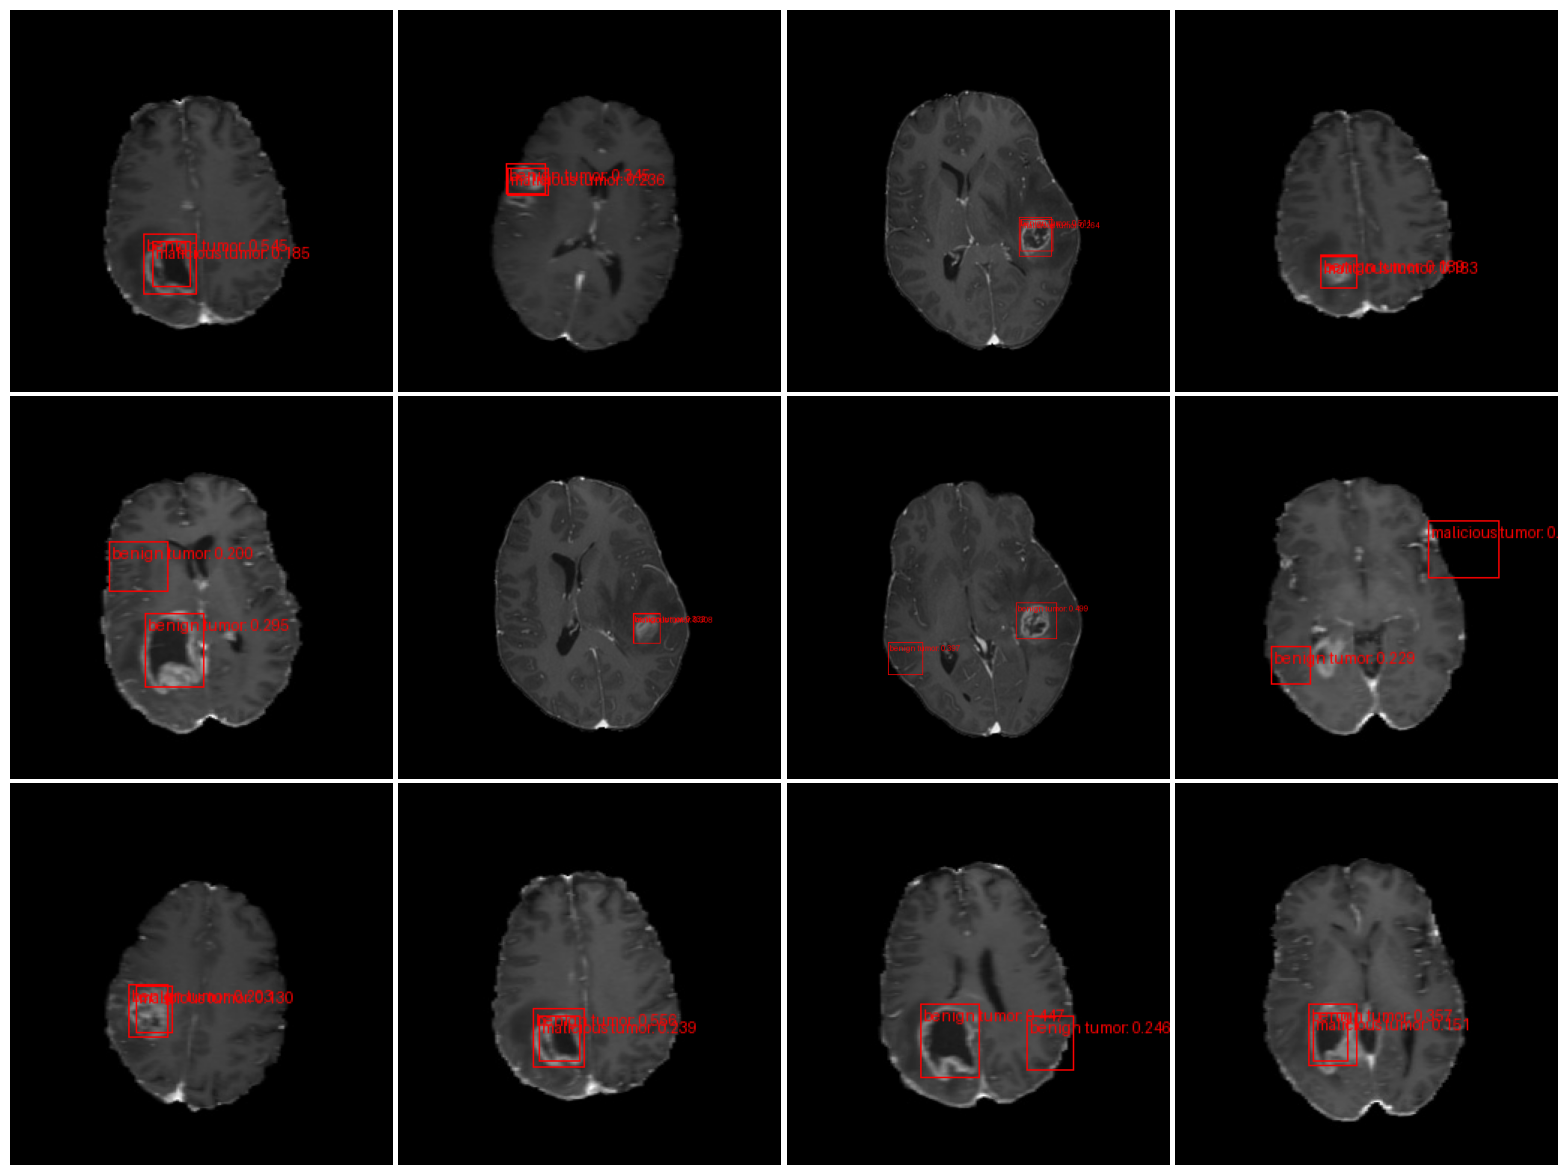

In [13]:
# Specify the folder path
folder_path = "/brain_tumor_tidy/brain_tumor_tidy/axial_t1wce_2_class/images/test"

# Get the list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png"))][1:13]  # Limit to the first 5 images

# Define transformations
eval_transform = get_transform(train=False)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model.eval()

# Define the label map
label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Create a figure with a grid of subplots
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Loop through the first 5 images
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path) 
    image = tv_tensors.Image(image)/ 255.0
    
    with torch.no_grad():
        x = eval_transform(image)  # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x])
        pred = predictions[0]

        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]
        
        # Sort predictions based on scores
        sorted_indices = torch.argsort(pred["scores"], descending=True)
        top_indices = sorted_indices[:2]  # Select top 3 indices

        # Get top predicted labels and boxes
        pred_labels = [int(pred["labels"][i]) for i in top_indices]
        pred_labels = [f"{label_map[label]}: {pred['scores'][i]:.3f}" for i, label in zip(top_indices, pred_labels)]
        pred_boxes = pred["boxes"][top_indices].long()

        output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index
        axs[row, col].imshow(output_image.permute(1, 2, 0).numpy())
        axs[row, col].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Save the figure
plt.savefig("faster_R_CNN_predict_axial.png")

# Display the figure
plt.show()

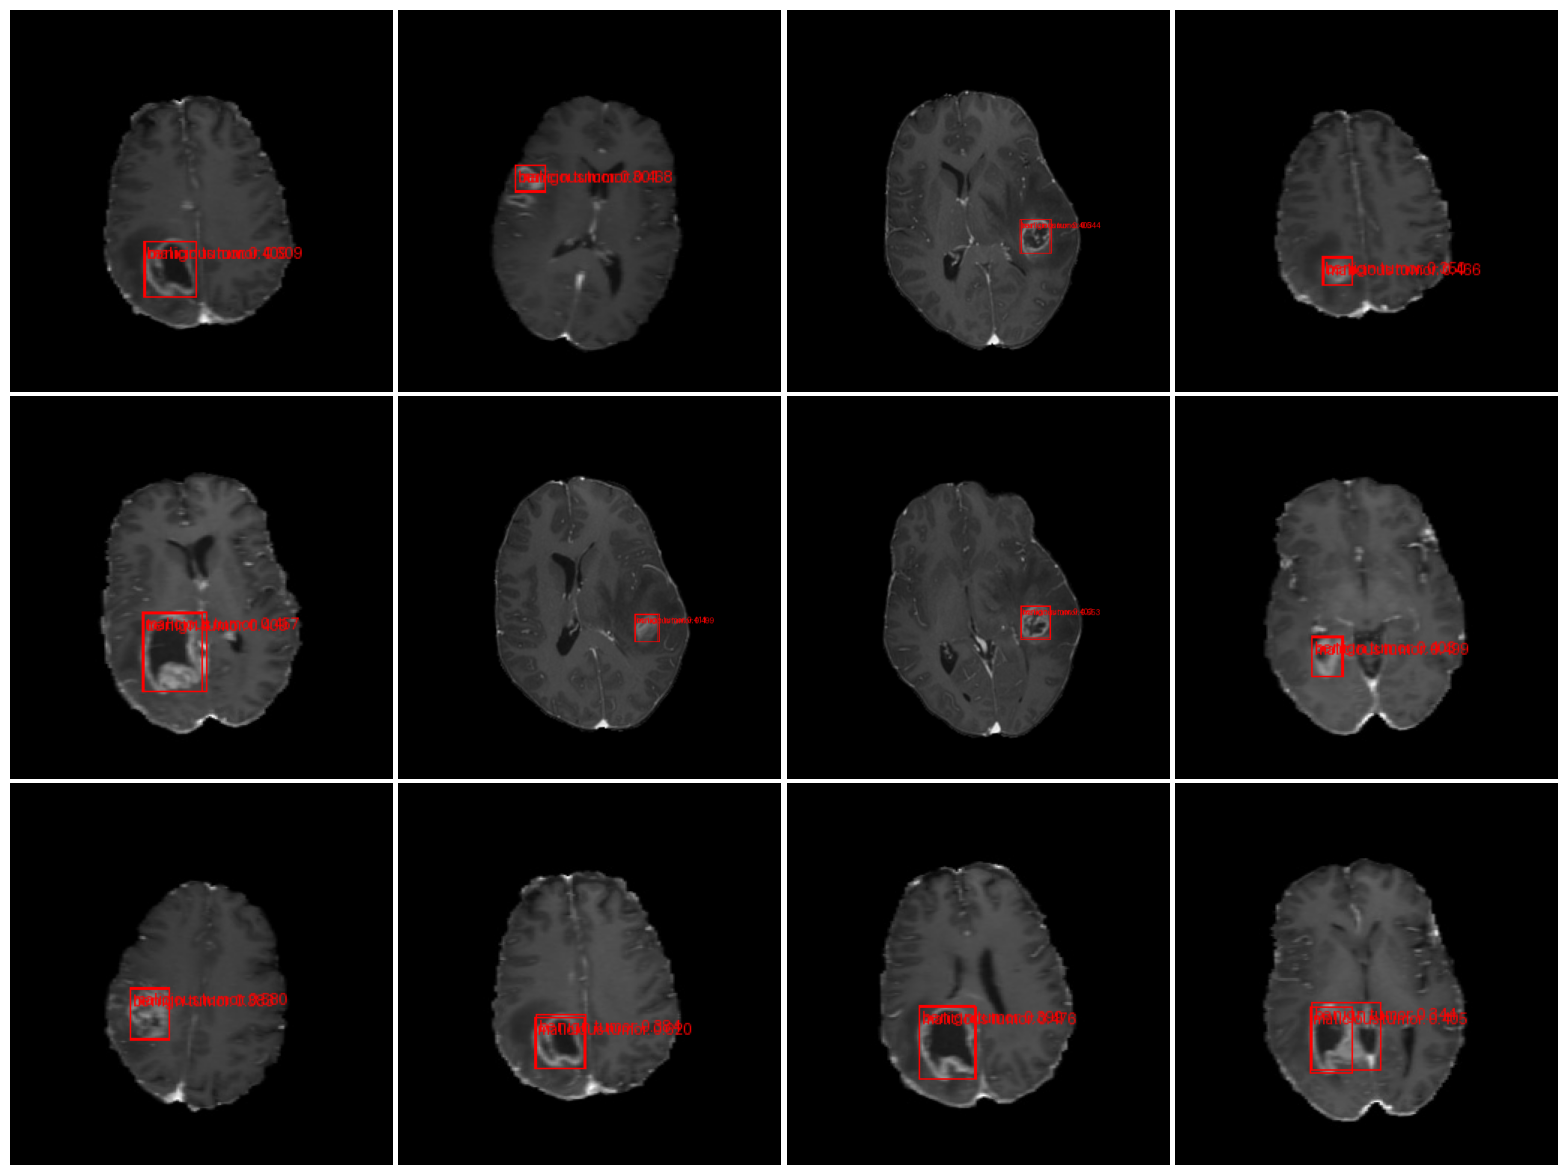

In [35]:
# Specify the folder path
folder_path = "/brain_tumor_tidy/brain_tumor_tidy/axial_t1wce_2_class/images/test"

# Get the list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png"))][1:13]  # Limit to the first 5 images

# Define transformations
eval_transform = get_transform(train=False)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
model.eval()

# Define the label map
label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Create a figure with a grid of subplots
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Loop through the first 5 images
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path) 
    image = tv_tensors.Image(image)/ 255.0
    
    with torch.no_grad():
        x = eval_transform(image)  # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x])
        pred = predictions[0]

        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]
        
        # Sort predictions based on scores
        sorted_indices = torch.argsort(pred["scores"], descending=True)
        top_indices = sorted_indices[:2]  # Select top 3 indices

        # Get top predicted labels and boxes
        pred_labels = [int(pred["labels"][i]) for i in top_indices]
        pred_labels = [f"{label_map[label]}: {pred['scores'][i]:.3f}" for i, label in zip(top_indices, pred_labels)]
        pred_boxes = pred["boxes"][top_indices].long()

        output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index
        axs[row, col].imshow(output_image.permute(1, 2, 0).numpy())
        axs[row, col].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Save the figure
plt.savefig("faster_R_CNN_predict_axial_trained_on_sagittal.png")

# Display the figure
plt.show()

## Coronal

In [15]:
# our dataset has three classes only - background, -ve tumor, +ve tumor
num_classes = 3
# use our dataset and defined transformations
dataset = brain_image_Dataset('/brain_tumor_tidy/brain_tumor_tidy/coronal_t1wce_2_class', get_transform(train=True), process="train")
dataset_test = brain_image_Dataset('/brain_tumor_tidy/brain_tumor_tidy/coronal_t1wce_2_class', get_transform(train=False), process="test")

# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# get the model using our helper function
model = get_model_detection(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.004,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/159]  eta: 0:01:02  lr: 0.000029  loss: 1.6447 (1.6447)  loss_classifier: 1.4331 (1.4331)  loss_box_reg: 0.0053 (0.0053)  loss_objectness: 0.2010 (0.2010)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 0.3942  data: 0.1750  max mem: 2012
Epoch: [0]  [100/159]  eta: 0:00:12  lr: 0.002558  loss: 0.2688 (0.3869)  loss_classifier: 0.1154 (0.2256)  loss_box_reg: 0.1083 (0.1117)  loss_objectness: 0.0229 (0.0457)  loss_rpn_box_reg: 0.0023 (0.0040)  time: 0.2049  data: 0.0058  max mem: 2012
Epoch: [0]  [158/159]  eta: 0:00:00  lr: 0.004000  loss: 0.2605 (0.3446)  loss_classifier: 0.1130 (0.1875)  loss_box_reg: 0.1013 (0.1152)  loss_objectness: 0.0167 (0.0382)  loss_rpn_box_reg: 0.0020 (0.0037)  time: 0.2074  data: 0.0060  max mem: 2012
Epoch: [0] Total time: 0:00:32 (0.2071 s / it)
creating index...
index created!
Test: [ 0/39] eta: 0:00:11 model_time: 0.0973 (0.0973) evaluator_time: 0.0048 (0.0048) time: 0.2874 data: 0.1839 max mem: 2012
Test: [38/39] eta: 0:00:00 model_time: 0.08

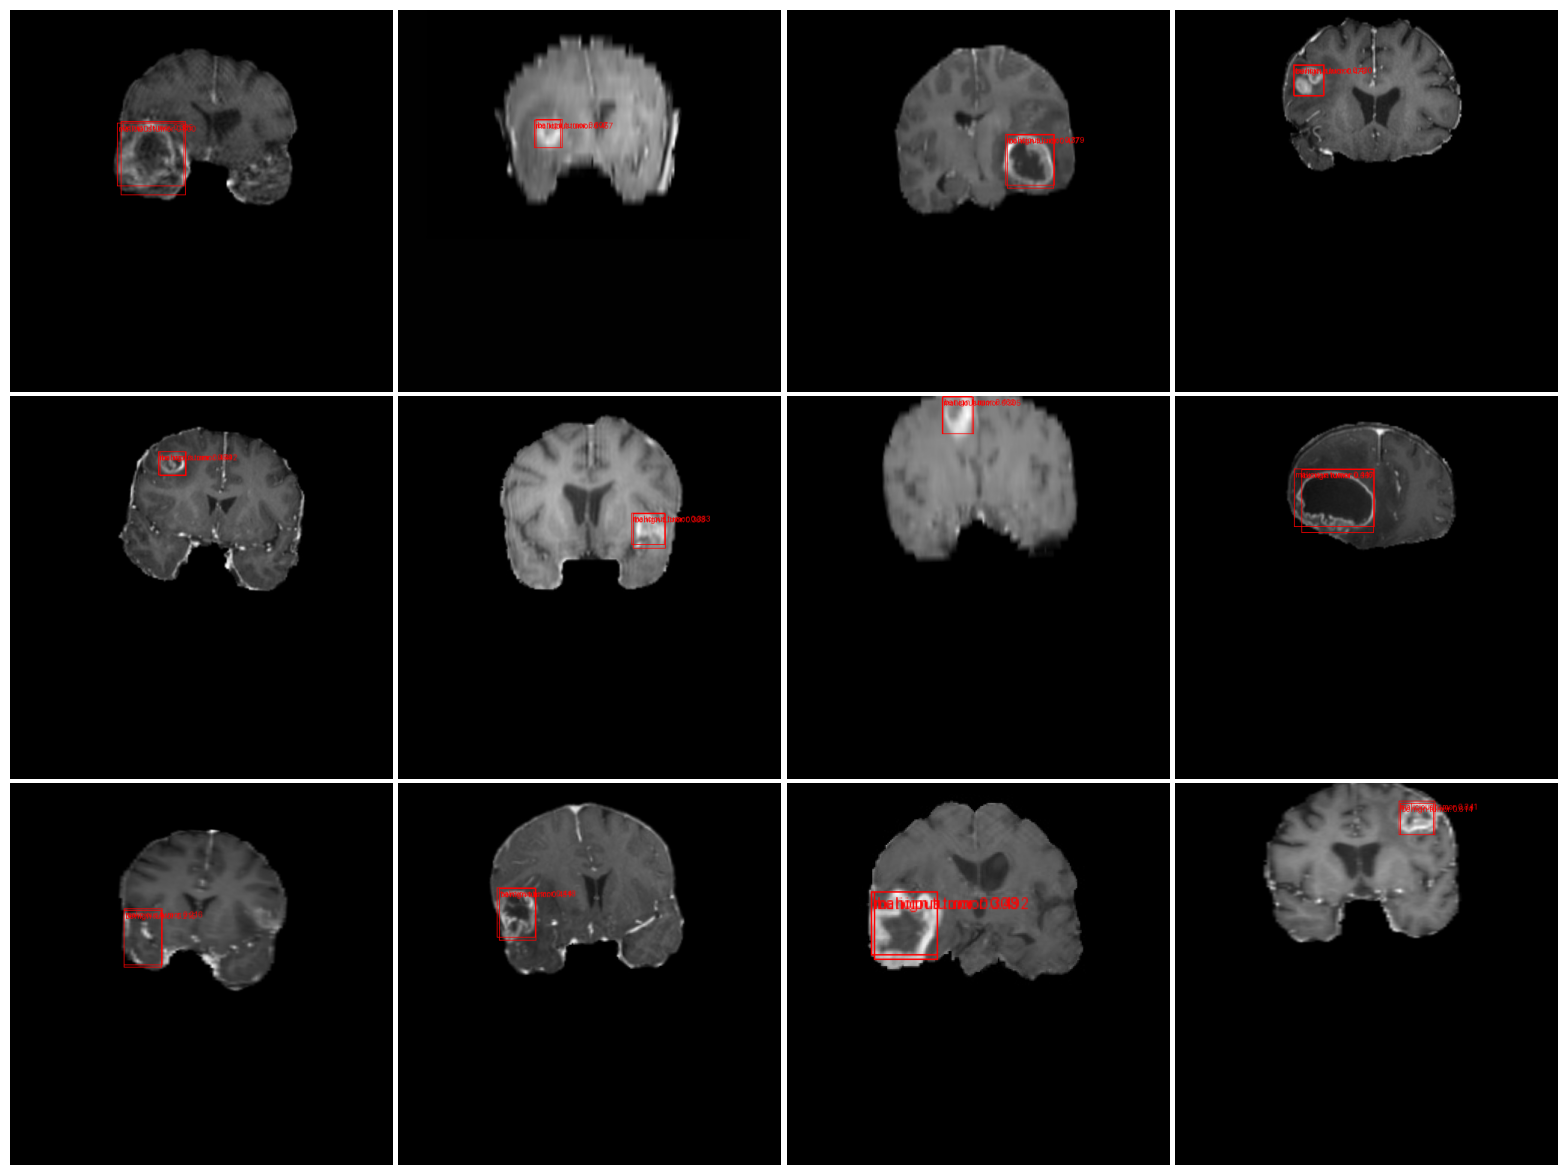

In [16]:
# Specify the folder path
folder_path = "/brain_tumor_tidy/brain_tumor_tidy/coronal_t1wce_2_class/images/test"

# Get the list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png"))][:12]  # Limit to the first 5 images

# Define transformations
eval_transform = get_transform(train=False)

# Load the pre-trained model
model.eval()

# Define the label map
label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Create a figure with a grid of subplots
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Loop through the first 5 images
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path) 
    image = tv_tensors.Image(image)/ 255.0
    
    with torch.no_grad():
        x = eval_transform(image)  # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x])
        pred = predictions[0]

        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]
        
        # Sort predictions based on scores
        sorted_indices = torch.argsort(pred["scores"], descending=True)
        top_indices = sorted_indices[:2]  # Select top 3 indices

        # Get top predicted labels and boxes
        pred_labels = [int(pred["labels"][i]) for i in top_indices]
        pred_labels = [f"{label_map[label]}: {pred['scores'][i]:.3f}" for i, label in zip(top_indices, pred_labels)]
        pred_boxes = pred["boxes"][top_indices].long()

        output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index
        axs[row, col].imshow(output_image.permute(1, 2, 0).numpy())
        axs[row, col].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Save the figure
plt.savefig("faster_R_CNN_predict_coronal.png")

# Display the figure
plt.show()

## Sagittal

In [33]:
# our dataset has three classes only - background, -ve tumor, +ve tumor
num_classes = 3
# use our dataset and defined transformations
dataset = brain_image_Dataset('/brain_tumor_tidy/brain_tumor_tidy/sagittal_t1wce_2_class', get_transform(train=True), process="train")
dataset_test = brain_image_Dataset('/brain_tumor_tidy/brain_tumor_tidy/sagittal_t1wce_2_class', get_transform(train=False), process="test")

# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# get the model using our helper function
model = get_model_detection(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.004,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/132]  eta: 0:00:53  lr: 0.000035  loss: 2.0536 (2.0536)  loss_classifier: 1.8835 (1.8835)  loss_box_reg: 0.0025 (0.0025)  loss_objectness: 0.1647 (0.1647)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 0.4086  data: 0.1851  max mem: 2014
Epoch: [0]  [100/132]  eta: 0:00:06  lr: 0.003085  loss: 0.2363 (0.3945)  loss_classifier: 0.0863 (0.2355)  loss_box_reg: 0.0991 (0.1082)  loss_objectness: 0.0220 (0.0471)  loss_rpn_box_reg: 0.0028 (0.0037)  time: 0.2062  data: 0.0059  max mem: 2014
Epoch: [0]  [131/132]  eta: 0:00:00  lr: 0.004000  loss: 0.2109 (0.3586)  loss_classifier: 0.0937 (0.2035)  loss_box_reg: 0.0845 (0.1077)  loss_objectness: 0.0274 (0.0437)  loss_rpn_box_reg: 0.0023 (0.0037)  time: 0.2080  data: 0.0062  max mem: 2014
Epoch: [0] Total time: 0:00:27 (0.2087 s / it)
creating index...
index created!
Test: [ 0/35] eta: 0:00:10 model_time: 0.0956 (0.0956) evaluator_time: 0.0045 (0.0045) time: 0.2870 data: 0.1847 max mem: 2014
Test: [34/35] eta: 0:00:00 model_time: 0.09

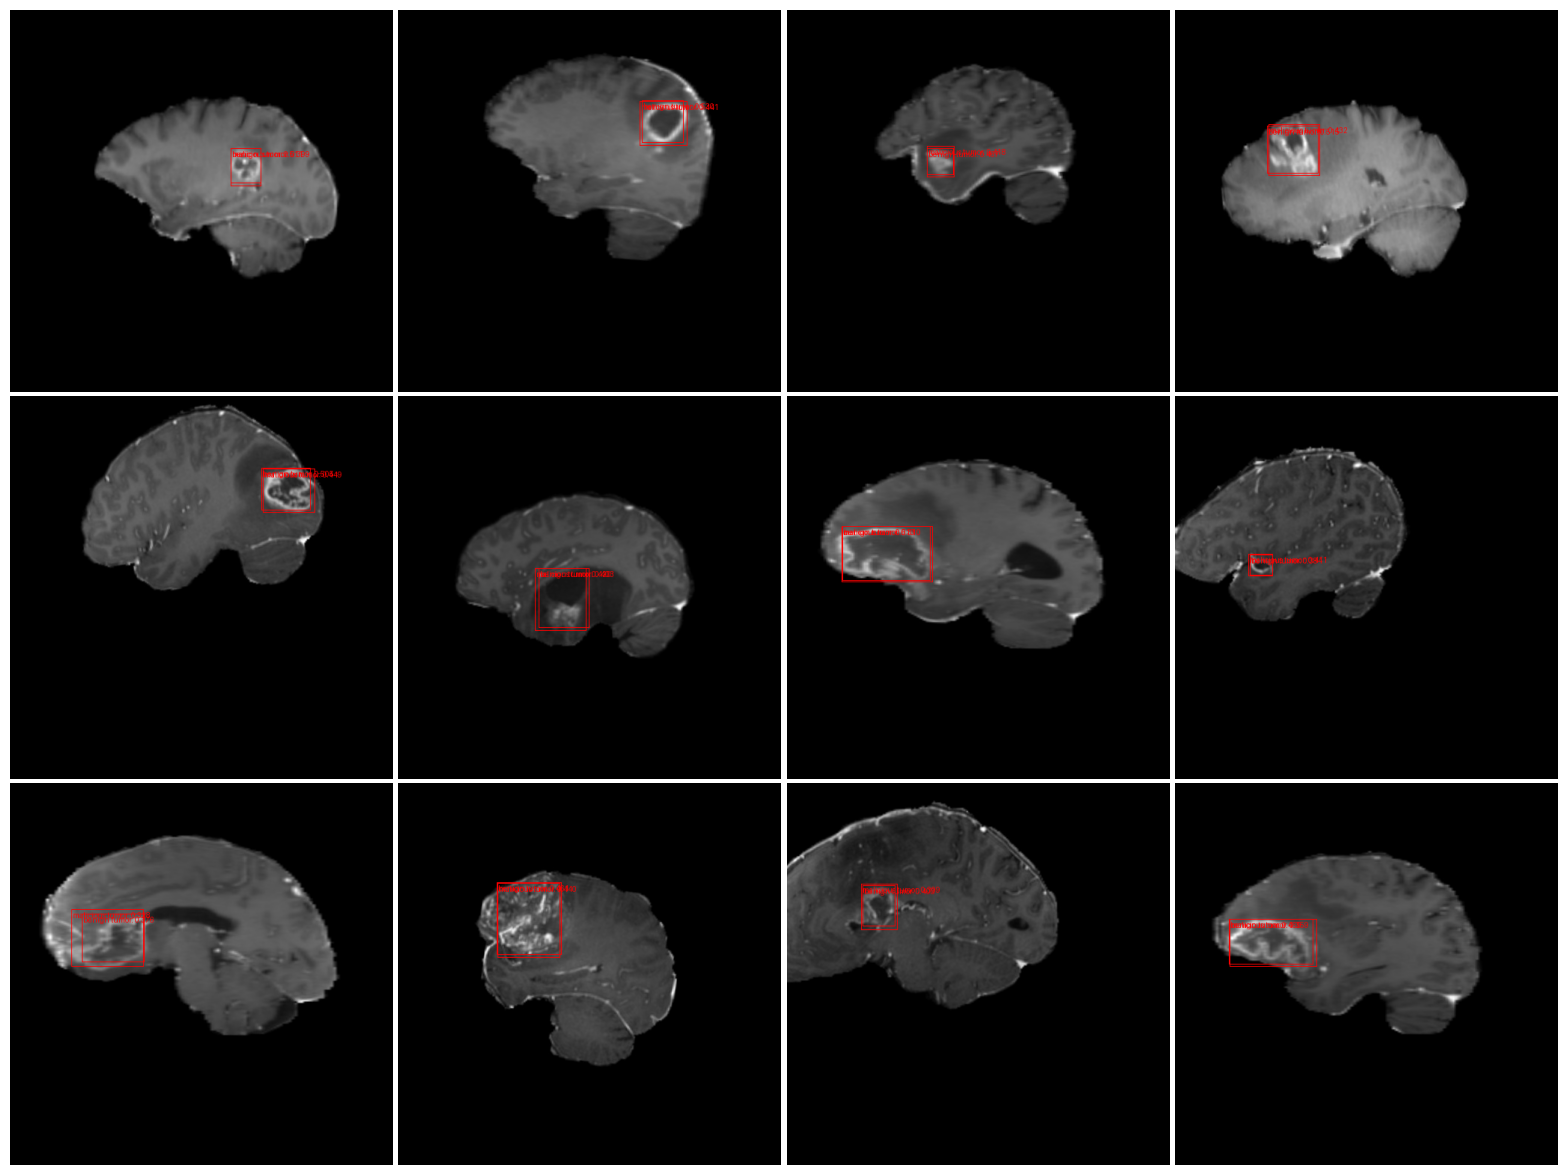

In [23]:
# Specify the folder path
folder_path = "/brain_tumor_tidy/brain_tumor_tidy/sagittal_t1wce_2_class/images/test"

# Get the list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png"))][:12]  # Limit to the first 5 images

# Define transformations
eval_transform = get_transform(train=False)

# Load the pre-trained model
model.eval()

# Define the label map
label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Create a figure with a grid of subplots
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

label_map = {0: "background", 1: "benign tumor", 2: "malicious tumor"}

# Loop through the first 5 images
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path) 
    image = tv_tensors.Image(image)/ 255.0
    
    with torch.no_grad():
        x = eval_transform(image)  # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x])
        pred = predictions[0]

        image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
        image = image[:3, ...]
        
        # Sort predictions based on scores
        sorted_indices = torch.argsort(pred["scores"], descending=True)
        top_indices = sorted_indices[:2]  # Select top 3 indices

        # Get top predicted labels and boxes
        pred_labels = [int(pred["labels"][i]) for i in top_indices]
        pred_labels = [f"{label_map[label]}: {pred['scores'][i]:.3f}" for i, label in zip(top_indices, pred_labels)]
        pred_boxes = pred["boxes"][top_indices].long()

        output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index
        axs[row, col].imshow(output_image.permute(1, 2, 0).numpy())
        axs[row, col].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Save the figure
plt.savefig("faster_R_CNN_predict_sagittal.png")

# Display the figure
plt.show()